In [1]:
!pip install cvrplib
import cvrplib
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import time 

In [2]:
def data_prepare(points, number_points):
    k = [0]
    for i in range(1, len(points) + 1):
        for j in range(i + 1,len(points) + 1):
            if (instance.distances[i][j]==0):
                k.append(j)
                demand[i]=instance.demands[i] + instance.demands[j]
    new_list = list(range(1, number_points + 1))
    for _ in range(1, len(k)):
        new_list.remove(k[_])
    print("Точки: ", list(range(1, number_points + 1)))
    return (new_list)

In [3]:
#number_customers - количество заказчиков,
#d_matrix - матрица расстояний между заказчиками.
#проходится по всем элементам матрицы расстояний с помощью вложенных циклов,определяет максимальное расстояние между любыми двумя заказчиками. 
#Это значение записывается в переменную "conuming_edge".
#Наконец, с использованием значений "number_customers" и "conuming_edge" вычисляется начальное значение параметра "tau_0" по формуле ((number_customers) * conuming_edge)**(-1), и это значение возвращается из функции.
def get_tau_0(number_customers, d_matrix):
    conuming_edge = 0
    for i in range(number_customers):
        for j in range(number_customers):
            if d_matrix[i][j] > conuming_edge:
                conuming_edge = d_matrix[i][j]
    tau_0 = ((number_customers) * conuming_edge)**(-1)
    return(tau_0)

Выбор следующей точки. На вход принимает текущую точку, список доступных непосещенных точек, q0 и beta.
Внутри функции с помощью формулы для вычисления вероятности перехода на следующую точку рассчитывается значение феромона для каждой непосещенной точки, исключая текущую и уже посещенные точки.
Далее, если случайное число меньше q0, то выбирается точка с максимальным значением феромона, иначе выбирается точка случайным образом с вероятностью, пропорциональной значениям феромонов

In [4]:

def point_selection(current_node, non_vis_list, q0, beta):
    feromon_values = np.array([(pheromon_matrix[current_node][point]) * ((1/distance_matrix[current_node][point])**beta) for point in non_vis_list if (distance_matrix[current_node][point]!=0)])
    if np.random.random_sample() < q0:
        return (non_vis_list[np.argmax(feromon_values)])
    else:
        return(np.random.choice(non_vis_list, p=feromon_values / sum(feromon_values)))

Обновление матрицы ферромонов
на вход:
- cur_route - текущий маршрут;
- cur_rout_cost - стоимость текущего маршрута;
- tau_mat - матрица феромонов;
- d_mat - матрица расстояний;
- alpha - коэффициент испарения феромонов.
Функция проходит циклом по всем точкам маршрута, начиная со второй (индекс 1). Для каждой пары точек матрица феромонов обновляется в соответствии с формулой, которая учитывает текущее значение феромонов, значение tau_0 и коэффициент испарения феромонов.
К стоимости маршрута добавляется расстояние между двумя текущими точками.

На выходе функция возвращает обновленную матрицу феромонов и новую стоимость маршрута.




In [5]:
def evaporation_and_cost(cur_route, cur_rout_cost, tau_mat,d_mat, alpha):                
    for i in range(1, len(cur_route)):
        _1, _2 = cur_route[i-1], cur_route[i]
        tau_mat[_1][_2] = tau_mat[_2][_1] = tau_mat[_1][_2] * (1 - alpha) + (alpha * tau_0)
        cur_rout_cost += d_mat[_1][_2]
    return(tau_mat, cur_rout_cost)

обновление матрицы ферромонов
Входные параметры:
- best_route - оптимальный маршрут, который нужно усилить
- pheromon_matrix - матрица феромонов, хранящая уровень феромонов на каждом ребре графа
- L - длина оптимального маршрута
- alpha - коэффициент испарения феромона

получаем новую матрицу ферромонов

In [6]:
def best_route_pher_upt(best_route, pheromon_matrix, L, alpha):
    for i in range(1, len(best_route)):
            _1, _2 = best_route[i-1], best_route[i]
            pheromon_matrix[_1][_2] = pheromon_matrix[_2][_1] = pheromon_matrix[_1][_2] * (1 - alpha) + alpha / L
    return(pheromon_matrix)

In [7]:
def plot_CVRP(route, minimal_route_cost, best_n_race):
    colors =["green","blue","grey","orange","red","pink","cyan","olive","brown","black","Purple","darkkhaki","darkmagenta","honeydew","lightcoral","lime"]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
    fig.suptitle(instance.name)
    for j in range(len(solution.routes)):
        x=[instance.coordinates[0][0]]
        y=[instance.coordinates[0][1]]
        for i in solution.routes[j]:
            x+=[instance.coordinates[i][0]]
            y+=[instance.coordinates[i][1]]
        x+=[instance.coordinates[0][0]]
        y+=[instance.coordinates[0][1]]
        ax1.plot(x,y)
        ax1.set_title(f'Reference solution\nTrucks:{instance.name[-1]} \nCost {solution.cost}')

    ax1.scatter(*instance.coordinates[instance.depot],color = "black")
    for i in instance.customers:
        ax1.scatter(*instance.coordinates[i],color = "black")

    def way(route,minimal_route_cost,ax):
        o = -1
        x = [instance.coordinates[0][0]]
        y = [instance.coordinates[0][1]]
        for i in route:
            x += [instance.coordinates[i][0]]
            y += [instance.coordinates[i][1]]
            #print(x,y)
            ax.plot(x,y,color=colors[o+1])
            ax.scatter(x,y, color="blue")
            if i == instance.depot:
                x = [instance.coordinates[i][0]]
                y = [instance.coordinates[i][1]]
                o+=1
        ax.scatter(*instance.coordinates[instance.depot],color = "black")
        ax.set_title(f'My solution\nTrucks: {best_n_race} \ncost {minimal_route_cost}')
        return(ax,o)
    
    ax2,o = way(route,minimal_route_cost,ax2)
    f = open('data.txt', 'a')
    f.write(instance.name+" ")
    f.write(instance.name[-1]+" ")
    f.write(str(solution.cost)+" ")
    f.write(str(best_n_race)+" ")
    f.write(str(minimal_route_cost)+" ")
    f.write('\n')
    f.close()
    fig.show()
    fig.savefig(instance.name)

Муравьиный алгоритм
на вход:
- new_list - список вершин, которые нужно посетить
- pheromon_matrix - матрица феромонов на ребрах графа
- alpha - коэффициент испарения феромона
- beta - коэффициент влияния расстояния на выбор следующей вершины
- q0 - вероятность выбора вершины с максимальным значением феромона

итерация алгоритма происходит, пока не будет достигнуто ограничение на количество итераций iters_limit или на количество итераций без улучшения результата idling_iters_limit.

Если текущий маршрут является лучшим, то обновляется лучший маршрут best_route и количество заездов best_n_race. Если маршрут не улучшается, то увеличивается счетчик безуспешных итераций idling_iters.



In [8]:
def ant_algorithm(new_list, pheromon_matrix, alpha, beta, q0):
    
    best_route = []
    minimal_route_cost = sys.maxsize
    iters = 1
    idling_iters = 0
    n_ants = 20
    while (iters <= iters_limit) and (idling_iters < idling_iters_limit):
        for ant in range(n_ants):
            current_route = [0]
            non_visited_points = new_list.copy()
            capacity_remains = capacity
            n_race = 1

            while len(non_visited_points)>0:
                current_point = current_route[-1]
                next_point = point_selection(current_point,non_visited_points,q0, beta)
                capacity_remains -= demand[next_point]

                if capacity_remains < 0:
                    current_route.append(0)
                    capacity_remains = capacity
                    n_race+=1
                else:
                    non_visited_points.remove(next_point)
                    current_route.append(next_point)
            current_route.append(0)
            
            current_route_cost = 0
            pheromon_matrix,current_route_cost = evaporation_and_cost(current_route,current_route_cost, 
                                                                pheromon_matrix,distance_matrix, alpha)    
            
            
            if current_route_cost < minimal_route_cost:
                best_route = current_route.copy()
                best_n_race = n_race
                minimal_route_cost = current_route_cost
                idling_iters += -1
            else:
                idling_iters += 1  
            iters += 1
        
        L = minimal_route_cost
        pheromon_matrix = best_route_pher_upt(best_route, pheromon_matrix, L, alpha)
        
        
    print("best_ants ", best_n_race)
    print("'Пассивных' иттераций", idling_iters)
    print("Итераций", iters)
    return(best_route, minimal_route_cost,best_n_race)

Точки:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
best_ants  7
'Пассивных' иттераций 9972
Итераций 10001


/var/folders/rs/fkk70l394gz79cxj0sdr_spc0000gn/T/ipykernel_14703/2687401332.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Время:  8.17301607131958 сек
alpha = 0.6 ,beta = 0.8


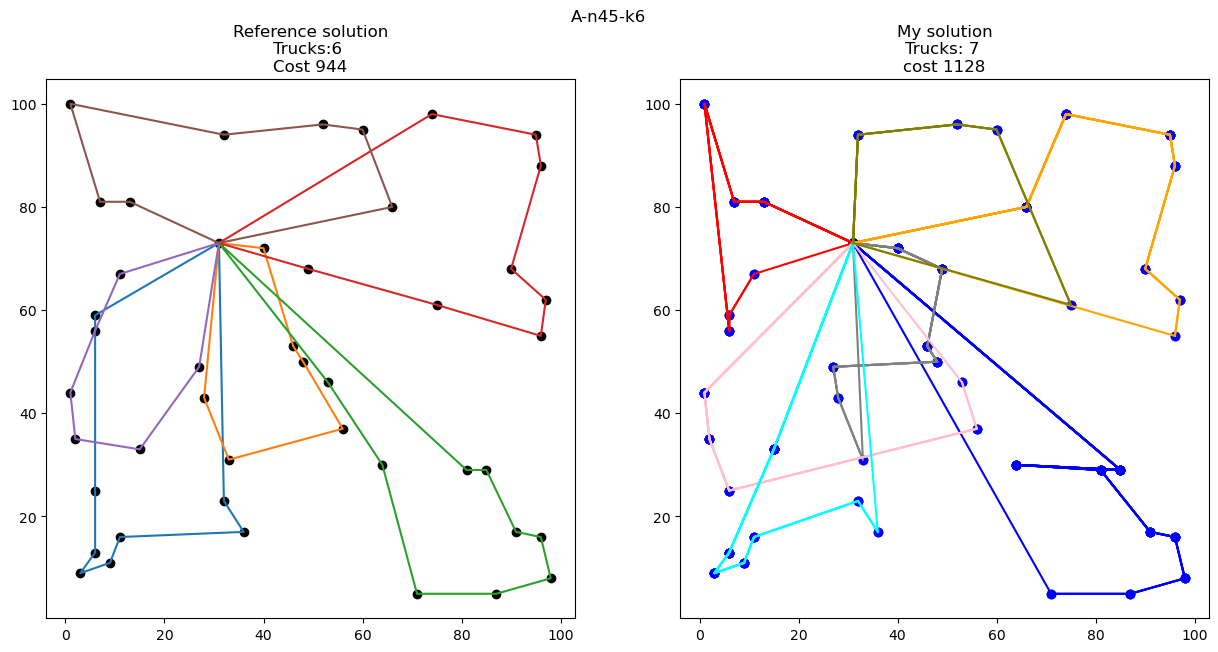

In [77]:
start_time = time.time()
instance, solution = cvrplib.download('A-n45-k6', solution=True)
iters_limit = 10000
idling_iters_limit = 10000

capacity, points, number_points, demand = instance.capacity, instance.customers, instance.n_customers, instance.demands
distance_matrix=list(instance.distances)
new_list = data_prepare(points, number_points)

alpha=0.6
beta=0.8
q0=0.7
#tau_0
tau_0 = get_tau_0(number_points,distance_matrix)
pheromon_matrix = list([tau_0 for _ in range(number_points+1)] for _ in range(number_points+1))


best_route, minimal_route_cost,best_n_race = ant_algorithm(new_list, pheromon_matrix,alpha, beta, q0)
plot_CVRP(best_route,minimal_route_cost, best_n_race )
end_time = time.time()
print("Время: ", end_time - start_time, "сек")
print("alpha =",alpha, ",beta =", beta)